Modification in forecast_dataloader.py- dont run

In [ ]:
import torch.utils.data as torch_data
import numpy as np
import torch
import pandas as pd


def normalized(data, normalize_method, norm_statistic=None):
    if normalize_method == 'min_max':
        if not norm_statistic:
            norm_statistic = dict(max=np.max(data, axis=0), min=np.min(data, axis=0))
        scale = norm_statistic['max'] - norm_statistic['min'] + 1e-5
        data = (data - norm_statistic['min']) / scale
        data = np.clip(data, 0.0, 1.0)
    elif normalize_method == 'z_score':
        if not norm_statistic:
            norm_statistic = dict(mean=np.mean(data, axis=0), std=np.std(data, axis=0))
        mean = norm_statistic['mean']
        std = norm_statistic['std']
        std = [1 if i == 0 else i for i in std]
        data = (data - mean) / std
        norm_statistic['std'] = std
    return data, norm_statistic


def de_normalized(data, normalize_method, norm_statistic):
    if normalize_method == 'min_max':
        if not norm_statistic:
            norm_statistic = dict(max=np.max(data, axis=0), min=np.min(data, axis=0))
        scale = norm_statistic['max'] - norm_statistic['min'] + 1e-8
        data = data * scale + norm_statistic['min']
    elif normalize_method == 'z_score':
        if not norm_statistic:
            norm_statistic = dict(mean=np.mean(data, axis=0), std=np.std(data, axis=0))
        mean = norm_statistic['mean']
        std = norm_statistic['std']
        std = [1 if i == 0 else i for i in std]
        data = data * std + mean
    return data


class ForecastDataset(torch_data.Dataset):
    def __init__(self, df, window_size, horizon, normalize_method=None, norm_statistic=None, interval=1):
        self.window_size = window_size
        self.interval = interval
        self.horizon = horizon
        self.normalize_method = normalize_method
        self.norm_statistic = norm_statistic
        df = pd.DataFrame(df)
        df = df.fillna(method='ffill', limit=len(df)).fillna(method='bfill', limit=len(df)).values
        self.data = df
        self.df_length = len(df)
        self.x_end_idx = self.get_x_end_idx()
        if normalize_method:
            self.data, _ = normalized(self.data, normalize_method, norm_statistic)

    def __getitem__(self, index):
        hi = self.x_end_idx[index]
        lo = hi - self.window_size
        train_data = self.data[lo: hi]
        target_data = self.data[hi:hi + self.horizon]
        # print(train_data.shape)
        m=[]
        M=[]
        S=[]
        for i in range(train_data.shape[1]):
          a=np.max(train_data[:,i])
          b=np.min(train_data[:,i])
          c=np.sum(train_data[:,i])
          m.append(b)
          M.append(a)
          S.append(c)
        train_data=np.vstack([train_data,[m],[M],[S]])
        x = torch.from_numpy(train_data).type(torch.float)
        y = torch.from_numpy(target_data).type(torch.float)
        return x, y

    def __len__(self):
        return len(self.x_end_idx)

    def get_x_end_idx(self):
        # each element `hi` in `x_index_set` is an upper bound for get training data
        # training data range: [lo, hi), lo = hi - window_size
        x_index_set = range(self.window_size, self.df_length - self.horizon + 1)
        x_end_idx = [x_index_set[j * self.interval] for j in range((len(x_index_set)) // self.interval)]
        return x_end_idx



Modification in handler.py - dont run

In [ ]:
import json
from datetime import datetime

from data_loader.forecast_dataloader import ForecastDataset, de_normalized
from models.base_model import Model
import torch
import torch.nn as nn
import torch.utils.data as torch_data
import numpy as np
import time
import os

from utils.math_utils import evaluate


def save_model(model, model_dir, epoch=None):
    if model_dir is None:
        return
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    epoch = str(epoch) if epoch else ''
    file_name = os.path.join(model_dir, epoch + '_stemgnn.pt')
    with open(file_name, 'wb') as f:
        torch.save(model, f)


def load_model(model_dir, epoch=None):
    if not model_dir:
        return
    epoch = str(epoch) if epoch else ''
    file_name = os.path.join(model_dir, epoch + '_stemgnn.pt')
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    if not os.path.exists(file_name):
        return
    with open(file_name, 'rb') as f:
        model = torch.load(f)
    return model


def inference(model, dataloader, device, node_cnt, window_size, horizon):
    forecast_set = []
    target_set = []
    model.eval()
    with torch.no_grad():
        for i, (inputs, target) in enumerate(dataloader):
            inputs = inputs.to(device)
            target = target.to(device)
            step = 0
            forecast_steps = np.zeros([inputs.size()[0], horizon, node_cnt], dtype=np.float)
            while step < horizon:
                forecast_result, a = model(inputs)
                len_model_output = forecast_result.size()[1]
                if len_model_output == 0:
                    raise Exception('Get blank inference result')
                inputs[:, :window_size - len_model_output, :] = inputs[:, len_model_output:window_size,
                                                                   :].clone()
                inputs[:, window_size - len_model_output:, :] = forecast_result.clone()
                forecast_steps[:, step:min(horizon - step, len_model_output) + step, :] = \
                    forecast_result[:, :min(horizon - step, len_model_output), :].detach().cpu().numpy()
                step += min(horizon - step, len_model_output)
            forecast_set.append(forecast_steps)
            target_set.append(target.detach().cpu().numpy())
    return np.concatenate(forecast_set, axis=0), np.concatenate(target_set, axis=0)


def validate(model, dataloader, device, normalize_method, statistic,
             node_cnt, window_size, horizon,
             result_file=None):
    start = datetime.now()
    forecast_norm, target_norm = inference(model, dataloader, device,
                                           node_cnt, window_size, horizon)
    if normalize_method and statistic:
        forecast = de_normalized(forecast_norm, normalize_method, statistic)
        target = de_normalized(target_norm, normalize_method, statistic)
    else:
        forecast, target = forecast_norm, target_norm
    score = evaluate(target, forecast)
    score_by_node = evaluate(target, forecast, by_node=True)
    end = datetime.now()

    score_norm = evaluate(target_norm, forecast_norm)
    print(f'NORM: MAPE {score_norm[0]:7.9%}; MAE {score_norm[1]:7.9f}; RMSE {score_norm[2]:7.9f}.')
    print(f'RAW : MAPE {score[0]:7.9%}; MAE {score[1]:7.9f}; RMSE {score[2]:7.9f}.')
    if result_file:
        if not os.path.exists(result_file):
            os.makedirs(result_file)
        step_to_print = 0
        forcasting_2d = forecast[:, step_to_print, :]
        forcasting_2d_target = target[:, step_to_print, :]

        np.savetxt(f'{result_file}/target.csv', forcasting_2d_target, delimiter=",")
        np.savetxt(f'{result_file}/predict.csv', forcasting_2d, delimiter=",")
        np.savetxt(f'{result_file}/predict_abs_error.csv',
                   np.abs(forcasting_2d - forcasting_2d_target), delimiter=",")
        np.savetxt(f'{result_file}/predict_ape.csv',
                   np.abs((forcasting_2d - forcasting_2d_target) / forcasting_2d_target), delimiter=",")

    return dict(mae=score[1], mae_node=score_by_node[1], mape=score[0], mape_node=score_by_node[0],
                rmse=score[2], rmse_node=score_by_node[2])


def train(train_data, valid_data, args, result_file):
    node_cnt = train_data.shape[1]
    model = Model(node_cnt, 2, args.window_size+3, args.multi_layer, horizon=args.horizon)
    model.to(args.device)
    if len(train_data) == 0:
        raise Exception('Cannot organize enough training data')
    if len(valid_data) == 0:
        raise Exception('Cannot organize enough validation data')

    if args.norm_method == 'z_score':
        train_mean = np.mean(train_data, axis=0)
        train_std = np.std(train_data, axis=0)
        normalize_statistic = {"mean": train_mean.tolist(), "std": train_std.tolist()}
    elif args.norm_method == 'min_max':
        train_min = np.min(train_data, axis=0)
        train_max = np.max(train_data, axis=0)
        normalize_statistic = {"min": train_min.tolist(), "max": train_max.tolist()}
    else:
        normalize_statistic = None
    if normalize_statistic is not None:
        with open(os.path.join(result_file, 'norm_stat.json'), 'w') as f:
            json.dump(normalize_statistic, f)

    if args.optimizer == 'RMSProp':
        my_optim = torch.optim.RMSprop(params=model.parameters(), lr=args.lr, eps=1e-08)
    else:
        my_optim = torch.optim.Adam(params=model.parameters(), lr=args.lr, betas=(0.9, 0.999))
    my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=my_optim, gamma=args.decay_rate)

    train_set = ForecastDataset(train_data, window_size=args.window_size, horizon=args.horizon,
                                normalize_method=args.norm_method, norm_statistic=normalize_statistic)
    valid_set = ForecastDataset(valid_data, window_size=args.window_size, horizon=args.horizon,
                                normalize_method=args.norm_method, norm_statistic=normalize_statistic)
    train_loader = torch_data.DataLoader(train_set, batch_size=args.batch_size, drop_last=False, shuffle=True,
                                         num_workers=0)
    valid_loader = torch_data.DataLoader(valid_set, batch_size=args.batch_size, shuffle=False, num_workers=0)

    forecast_loss = nn.MSELoss(reduction='mean').to(args.device)

    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        total_params += param
    print(f"Total Trainable Params: {total_params}")

    best_validate_mae = np.inf
    validate_score_non_decrease_count = 0
    performance_metrics = {}
    for epoch in range(args.epoch):
        epoch_start_time = time.time()
        model.train()
        loss_total = 0
        cnt = 0
        for i, (inputs, target) in enumerate(train_loader):
            inputs = inputs.to(args.device)
            target = target.to(args.device)
            model.zero_grad()
            forecast, _ = model(inputs)
            loss = forecast_loss(forecast, target)
            cnt += 1
            loss.backward()
            my_optim.step()
            loss_total += float(loss)
        print('| end of epoch {:3d} | time: {:5.2f}s | train_total_loss {:5.4f}'.format(epoch, (
                time.time() - epoch_start_time), loss_total / cnt))
        save_model(model, result_file, epoch)
        if (epoch+1) % args.exponential_decay_step == 0:
            my_lr_scheduler.step()
        if (epoch + 1) % args.validate_freq == 0:
            is_best_for_now = False
            print('------ validate on data: VALIDATE ------')
            performance_metrics = \
                validate(model, valid_loader, args.device, args.norm_method, normalize_statistic,
                         node_cnt, args.window_size+3, args.horizon,
                         result_file=result_file)
            if best_validate_mae > performance_metrics['mae']:
                best_validate_mae = performance_metrics['mae']
                is_best_for_now = True
                validate_score_non_decrease_count = 0
            else:
                validate_score_non_decrease_count += 1
            # save model
            if is_best_for_now:
                save_model(model, result_file)
        # early stop
        if args.early_stop and validate_score_non_decrease_count >= args.early_stop_step:
            break
    return performance_metrics, normalize_statistic


def test(test_data, args, result_train_file, result_test_file):
    with open(os.path.join(result_train_file, 'norm_stat.json'),'r') as f:
        normalize_statistic = json.load(f)
    model = load_model(result_train_file)
    node_cnt = test_data.shape[1]
    test_set = ForecastDataset(test_data, window_size=args.window_size, horizon=args.horizon,
                               normalize_method=args.norm_method, norm_statistic=normalize_statistic)
    test_loader = torch_data.DataLoader(test_set, batch_size=args.batch_size, drop_last=False,
                                        shuffle=False, num_workers=0)
    performance_metrics = validate(model, test_loader, args.device, args.norm_method, normalize_statistic,
                      node_cnt, args.window_size+3, args.horizon,
                      result_file=result_test_file)
    mae, mape, rmse = performance_metrics['mae'], performance_metrics['mape'], performance_metrics['rmse']
    print('Performance on test set: MAPE: {:5.2f} | MAE: {:5.2f} | RMSE: {:5.4f}'.format(mape, mae, rmse))


In [ ]:
pip install yfinance

     |████████████████████████████████| 63 kB 1.2 MB/s 
     |████████████████████████████████| 6.4 MB 11.8 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from pandas import datetime
from datetime import datetime
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from datetime import timedelta
from time import time
import pywt
import copy
# from PyEMD import EMD

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [ ]:
pip install scipy

In [ ]:
pip install torch==1.7.1 torchvision==0.8.2

     |████████████████████████████████| 776.8 MB 15 kB/s 
     |████████████████████████████████| 12.8 MB 33.6 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0+cu113
    Uninstalling torchvision-0.12.0+cu113:
      Successfully uninstalled torchvision-0.12.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.7.1 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.7.1 which is incompatible.


# remaining

In [ ]:
def WT(index_list, wavefunc='db4', lv=7, m=1, n=7, plot=True):
    
    '''
    WT: Wavelet Transformation Function
    index_list: Input Sequence;
   
    lv: Decomposing Level；
 
    wavefunc: Function of Wavelet, 'db4' default；
    
    m, n: Level of Threshold Processing
   
    '''
    # Decomposing 
    coeff = pywt.wavedec(index_list,wavefunc,mode='sym',level=lv)   #  Decomposing by levels，cD is the details coefficient
    sgn = lambda x: 1 if x > 0 else -1 if x < 0 else 0 # sgn function 
    # Denoising
    # Soft Threshold Processing Method
    for i in range(m,n+1):   #  Select m~n Levels of the wavelet coefficients，and no need to dispose the cA coefficients(approximation coefficients)
        cD = coeff[i]
        Tr = np.sqrt(2*np.log2(len(cD)))  # Compute Threshold
        for j in range(len(cD)):
            if cD[j] >= Tr:
                coeff[i][j] = sgn(cD[j]) * (np.abs(cD[j]) -  Tr)  # Shrink to zero
            else:
                coeff[i][j] = 0   # Set to zero if smaller than threshold

    # Reconstructing
    coeffs = {}
    for i in range(len(coeff)):
        coeffs[i] = copy.deepcopy(coeff)
        for j in range(len(coeff)):
            if j != i:
                coeffs[i][j] = np.zeros_like(coeff[j])
    
    for i in range(len(coeff)):
        coeff[i] = pywt.waverec(coeffs[i], wavefunc)
        if len(coeff[i]) > len(index_list):
            coeff[i] = coeff[i][:-1]
        
    if plot:     
        denoised_index = np.sum(coeff, axis=0)   
        data = pd.DataFrame({'CLOSE': index_list, 'denoised': denoised_index})
        data.plot(figsize=(10,10),subplots=(2,1))
        data.plot(figsize=(10,5))
    denoised_index = np.sum(coeff, axis=0)   
    return coeff

In [ ]:
WMT = yf.download('GOOG', 
                      start='2010-01-01', 
                      end='2021-06-01', 
                      progress=False,
)

In [ ]:
df1=pd.DataFrame(WMT)
df1=df1['Close']

In [ ]:
df1=df1.to_frame()

In [ ]:
df1['Close']=df1['Close'].apply(lambda x: float(x))

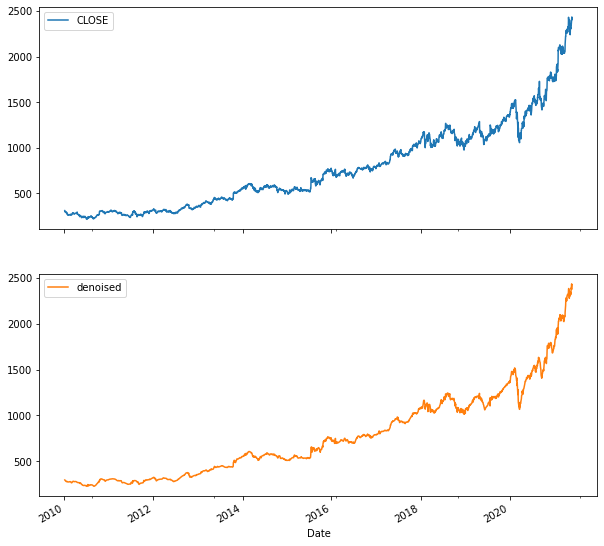

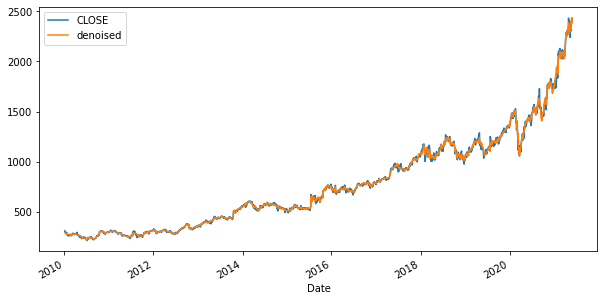

In [ ]:
s=WT(df1['Close'])

In [ ]:
s = pd.DataFrame(np.array(s).T)

In [ ]:
# s = pd.DataFrame(np.array(s).T)
s.columns = ['a','b','c','d','e','f']
s['Total']=s['a']+s['b']+s['c']+s['d']+s['e']+s['f']

In [ ]:
s

,a,b,c,d,e,f,Total
0,291.761671,2.456417,1.730779,0.301913,0.289474,0.000000,296.540254
1,290.419282,2.252660,1.518071,0.805639,-0.224143,0.000000,294.771509
2,289.058665,1.923527,1.325313,0.803340,-0.244296,0.000000,292.866549
3,287.684687,1.457116,1.164536,0.234105,0.109436,0.000000,290.649881
4,286.235038,0.964502,0.841619,-0.538386,0.303945,0.000000,287.806717
...,...,...,...,...,...,...,...
2866,2400.098687,-18.647930,-2.953915,46.738768,-5.149680,12.359338,2432.445267
2867,2401.820786,-11.388069,-3.574910,34.707812,12.185642,-6.851099,2426.900161
2868,2403.143636,-4.209304,-4.244475,17.812642,12.071648,3.716852,2428.291000
2869,2403.933591,3.879646,-4.940158,-11.887005,-4.306738,-2.906913,2383.772424


In [ ]:
s.to_csv('WT_data.csv',index=False,header=False)

In [ ]:
! git clone https://github.com/microsoft/StemGNN

Cloning into 'StemGNN'...
remote: Enumerating objects: 468, done.
remote: Total 468 (delta 0), reused 0 (delta 0), pack-reused 468
Receiving objects: 100% (468/468), 14.55 MiB | 6.12 MiB/s, done.
Resolving deltas: 100% (250/250), done.


In [ ]:
ls


data_loader/  main.py  output/    requirements.txt
dataset/      models/  README.md  utils/


In [ ]:
cd ..

/content/StemGNN


In [ ]:
!python main.py

In [ ]:
cd output

/content/StemGNN/output


In [ ]:
ls

WT_data/


In [ ]:
cd WT_data

/content/StemGNN/output/WT_data


In [ ]:
cd test

/content/StemGNN/output/WT_data/test


In [ ]:
ls

predict_abs_error.csv  predict_ape.csv  predict.csv  target.csv


In [ ]:
predicted=pd.read_csv('predict.csv')
target=pd.read_csv('target.csv')

In [ ]:
predicted=std_scaler.inverse_transform(predicted.to_numpy())

In [ ]:
target=std_scaler.inverse_transform(target.to_numpy())

In [ ]:
predicted=pd.DataFrame(predicted)
target=pd.DataFrame(target)


In [ ]:
predicted

,0,1,2,3,4,5,6,7,8
0,5214.243456,-0.671262,0.307547,0.010670,-0.101002,0.049017,-0.001879,0.005411,5075.289840
1,7727.224423,1.094888,-0.813531,-0.358992,0.007627,0.073990,0.046248,0.000099,6229.451508
2,7488.599203,-4.346102,2.012916,0.024109,0.157823,0.092039,0.047691,-0.003672,7911.366529
3,8320.235938,-1.849193,0.971679,0.075654,0.145932,0.006572,0.500736,-0.002743,9184.946773
4,9468.452429,7.315400,2.310870,0.568821,0.146586,-0.024882,0.011963,0.009111,9782.838536
...,...,...,...,...,...,...,...,...,...
214,11022.226425,9.374397,0.260610,-0.959351,0.703912,0.069172,0.384889,0.008023,10954.876535
215,11193.372256,8.039993,0.124641,-0.956023,0.944929,0.013159,0.262510,0.004827,11271.692451
216,10988.940021,8.179256,-0.050053,-0.935688,0.959910,0.042851,0.125149,0.002428,11048.058803
217,10970.986809,6.205909,-0.237044,-0.829080,1.227265,0.043985,0.065042,0.000730,11090.923522


In [ ]:
target

,0,1,2,3,4,5,6,7,8
0,11702.965843,0.920870,5.997779,-0.007528,-1.268442,0.507590,-1.419724e-01,8.157407e-20,11950.713735
1,11723.736466,0.941804,5.602536,-0.071614,-1.406747,0.388932,3.363552e-01,8.157407e-20,12051.214673
2,11744.511623,0.962736,5.204065,-0.122251,-1.376458,0.203148,3.294278e-01,8.157407e-20,12031.598048
3,11765.226615,0.983130,4.847306,-0.152630,-1.022943,-0.088513,-1.303992e-01,8.157407e-20,11908.093399
4,11785.991057,1.003629,4.459937,-0.222122,-0.782655,-0.402621,-1.917691e-01,8.157407e-20,11873.471212
...,...,...,...,...,...,...,...,...,...
214,14702.569972,6.026376,-1.153497,-7.874947,1.287758,0.042960,-1.631481e-19,8.157407e-20,14686.995491
215,14709.999825,6.081024,-1.152678,-6.483310,2.410951,0.058007,-1.631481e-19,8.157407e-20,14820.182134
216,14717.361273,6.140245,-1.156933,-5.535688,3.021915,0.059302,-1.631481e-19,8.157407e-20,14902.413439
217,14724.650194,6.203144,-1.163844,-5.033513,3.084431,0.045510,-1.631481e-19,8.157407e-20,14931.148161


In [ ]:
p=predicted.sum(axis=1)

In [ ]:
t=target.sum(axis=1)

In [ ]:
p=predicted.iloc[:,-1]

In [ ]:
t=target.iloc[:,-1]

In [ ]:
t

0      1417.168542
1      1416.917471
2      1414.177151
3      1410.570902
4      1434.943286
          ...     
230    2395.622810
231    2390.433097
232    2415.116013
233    2418.794045
234    2429.524635
Name: 1.421028704986067623e+03, Length: 235, dtype: float64

In [ ]:
p

0      1340.750975
1      1381.400943
2      1371.191410
3      1388.218415
4      1389.688387
          ...     
230    1480.396043
231    1437.102141
232    1507.184428
233    1553.794428
234    1467.154790
Name: 1.368207990934163263e+03, Length: 235, dtype: float64

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(t,p, squared=False) 

470.58567926245587

In [ ]:
def mape(actual,pred):
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [ ]:
result=mape(t,p)
print(result)

1.540999853077695


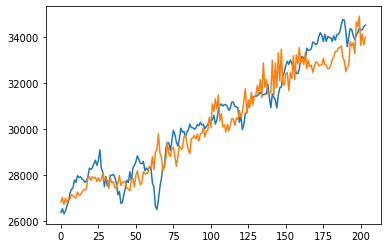

In [ ]:
plt.plot(n)
plt.plot(predicted.iloc[:,-1])

In [ ]:
z=np.array(df1['Close'])

In [ ]:
z=z[-206:]

In [ ]:
z.shape

(206,)

In [ ]:
t=np.array(t)

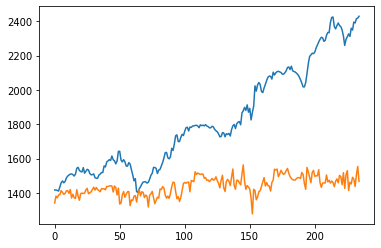

In [ ]:
plt.plot(t)
plt.plot(p)

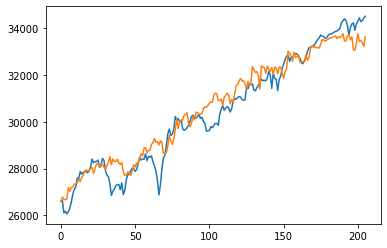

In [ ]:
plt.plot(target.iloc[:,-1])
plt.plot(predicted.iloc[:,-1])

# EMD Method

In [ ]:
pip install EMD-signal

     |████████████████████████████████| 64 kB 1.8 MB/s 
     |████████████████████████████████| 81 kB 7.6 MB/s 
     |████████████████████████████████| 65 kB 3.5 MB/s 


In [ ]:
WMT = yf.download('DJI', 
                      start='2016-01-01', 
                      end='2021-06-01', 
                      progress=False,
)

In [ ]:
df=pd.DataFrame(WMT)
df=df['Close']

In [ ]:
df

Date
2016-01-04    17148.900391
2016-01-05    17158.699219
2016-01-06    16906.500000
2016-01-07    16514.099609
2016-01-08    16346.500000
                  ...     
2021-05-24    34394.000000
2021-05-25    34312.500000
2021-05-26    34323.101562
2021-05-27    34464.601562
2021-05-28    34529.398438
Name: Close, Length: 1201, dtype: float64

In [ ]:
df=df.to_frame()

In [ ]:
df['Close']=df['Close'].apply(lambda x: float(x))

In [ ]:
x=np.array(df['Close'])
t=np.arange(1,len(df)+1)

In [ ]:
IMF = EMD().emd(x,t)

In [ ]:
IMF=np.transpose(IMF)
df1=pd.DataFrame(IMF)

In [ ]:
df1

,0,1,2,3,4,5,6
0,247.063748,484.022610,365.140391,-676.494257,-573.387844,-1613.958071,18916.513814
1,246.719528,488.145857,375.484811,-678.464586,-575.396567,-1614.639246,18916.849421
2,67.356107,412.146762,381.719293,-679.618014,-577.050153,-1615.320070,18917.266075
3,-195.989752,282.907289,383.699722,-679.938564,-578.342546,-1616.000535,18917.763995
4,-215.305631,137.515514,381.310872,-679.415356,-579.268164,-1616.680634,18918.343398
...,...,...,...,...,...,...,...
1196,134.097863,276.326118,-206.945851,-206.307790,577.292360,4538.689536,29280.847763
1197,-31.559580,394.918835,-237.552213,-208.128082,575.321918,4537.203523,29282.295599
1198,-100.780954,500.869435,-259.450830,-208.218099,572.323205,4534.722105,29283.636699
1199,9.258520,548.572307,-271.160538,-206.495707,568.299523,4531.256020,29284.871436


In [ ]:
df1.drop([0,1,2],axis=1,inplace=True)

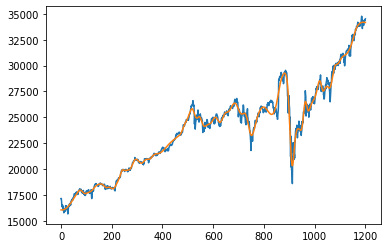

In [ ]:
plt.plot(x)
plt.plot(z)

In [ ]:
z=df1[6]+df1[5]+df1[4]+df1[3]

In [ ]:
df1[7]=z

In [ ]:
df1

,3,4,5,6
0,-676.494257,-573.387844,-1613.958071,18916.513814
1,-678.464586,-575.396567,-1614.639246,18916.849421
2,-679.618014,-577.050153,-1615.320070,18917.266075
3,-679.938564,-578.342546,-1616.000535,18917.763995
4,-679.415356,-579.268164,-1616.680634,18918.343398
...,...,...,...,...
1196,-206.307790,577.292360,4538.689536,29280.847763
1197,-208.128082,575.321918,4537.203523,29282.295599
1198,-208.218099,572.323205,4534.722105,29283.636699
1199,-206.495707,568.299523,4531.256020,29284.871436


In [ ]:
df1.to_csv('EDM_data.csv',header=False,index=False)

In [ ]:
t=df1.sum(axis=1)

In [ ]:
cd StemGNN

/content/StemGNN


In [ ]:
cd ..

/content/StemGNN


In [ ]:
z=df1.iloc[:,-1]+df1.iloc[:,-2]+df1.iloc[:,-3]

In [ ]:
z

0       16729.167899
1       16726.813608
2       16724.895852
3       16723.420914
4       16722.394601
            ...     
1196    34396.829659
1197    34394.821040
1198    34390.682009
1199    34384.426980
1200    34376.097736
Length: 1201, dtype: float64

In [ ]:
z=np.array(z)

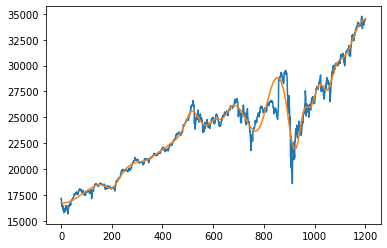

In [ ]:
plt.plot(x)
plt.plot(z)

In [ ]:
! python main.py

Training configs: Namespace(batch_size=32, dataset='EDM_data', decay_rate=0.5, device='cpu', dropout_rate=0.5, early_stop=False, epoch=20, evaluate=True, exponential_decay_step=5, horizon=1, leakyrelu_rate=0.2, lr=0.001, multi_layer=7, norm_method='z_score', optimizer='Adam', test_length=2, train=True, train_length=8, valid_length=1, validate_freq=1, window_size=32)
Total Trainable Params: 17118406
/content/StemGNN/models/base_model.py:49: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  ffted = torch.rfft(input, 1, onesided=False)
/content/StemGNN/models/base_model.py:58: UserWarning: The function torch.irfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft

In [ ]:
cd output

/content/StemGNN/output


In [ ]:
cd EDM_data

/content/StemGNN/output/EDM_data


In [ ]:
cd test

/content/StemGNN/output/EDM_data/test


In [ ]:
cd ..

/content/StemGNN/output
